In [1]:
!pip3 install git+https://github.com/holounic/Bayesian-Optimization.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/holounic/Bayesian-Optimization.git to /tmp/pip-req-build-ba87u217
  Running command git clone -q https://github.com/holounic/Bayesian-Optimization.git /tmp/pip-req-build-ba87u217
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning https://github.com/holounic/pyDOE to /tmp/pip-install-ky3w9mi8/pydoe_a50355fd6c4e417ca578599257fb3bf6
  Running command git clone -q https://github.com/holounic/pyDOE /tmp/pip-install-ky3w9mi8/pydoe_a50355fd6c4e417ca578599257fb3bf6
     |████████████████████████████████| 316 kB 7.3 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Created wheel for bayes-optim: filename=bayes_optim-0.2.7-py3-none-any.whl size=145056 sha256=b656cab83840552fe23b25773b47066d9ea3027dbebe6ae4fd03d872331ff186
  Stored in directory: /tmp/pip-ephem-wheel-cache-i

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from benchmark.bbobbenchmarks import F13
from bayes_optim.search_space import RealSpace

In [9]:
dim = 2
lb, ub = -5, 5
space = RealSpace([lb, ub]) * dim
f_name = 'f13'
f = F13

samples = space.sample(50000)

In [10]:
def fix_numeric_data(df):
  regrets = [float(x[1:-1]) for x in df['regret'].tolist()]
  df['regret'] = regrets
  return df

In [11]:
def minmax_normalisation():
  minmax = []
  for i in range(50):
    func = f(i)
    minmax.append(func(samples).max() - func.getfopt())
  return minmax

In [12]:
def abs_normalisation():
  n = []
  for i in range(50):
    func = f(i)
    n.append(func(samples).mean() - func.getfopt())
  return n

In [30]:
cma_es = fix_numeric_data(pd.read_csv(f'{f_name}_cma_es_doe_normalized.csv')[['regret', 'f_s']]).rename(columns={'regret': 'cma_es_regret'})
cma_es_init = fix_numeric_data(pd.read_csv(f'{f_name}_lhs_initial_doe_normalized.csv')[['regret', 'f_s']]).rename(columns={'regret': 'lhs_init_regret'})
uniform = fix_numeric_data(pd.read_csv(f'uniform_doe_{f_name}.csv')[['regret', 'f_s']]).rename(columns={'regret': 'uniform_regret'})
lhs = fix_numeric_data(pd.read_csv(f'lhs_doe_{f_name}.csv')[['regret', 'f_s']]).rename(columns={'regret': 'lhs_regret'})
halton = fix_numeric_data(pd.read_csv(f'halton_doe_{f_name}.csv')[['regret', 'f_s']]).rename(columns={'regret': 'halton_regret'})
sobol = fix_numeric_data(pd.read_csv(f'sobol_doe_{f_name}.csv')[['regret', 'f_s']]).rename(columns={'regret': 'sobol_regret'})
stats = cma_es.merge(uniform.merge(lhs.merge(sobol.merge(halton.merge(cma_es_init)))))
stats['minmax_norm'] = minmax_normalisation()
stats['abs_norm'] = abs_normalisation()
stats.head()

,cma_es_regret,f_s,uniform_regret,lhs_regret,sobol_regret,halton_regret,lhs_init_regret,minmax_norm,abs_norm
0,27.551145,0,0.870159,22.434218,28.327393,44.224621,24.290852,1982.336919,668.680911
1,7.315273,1,11.598317,31.876777,20.652986,14.969763,2.579814,2327.435818,756.574452
2,3.759295,2,41.106288,32.683096,9.836162,34.083032,11.746058,1734.871714,520.072987
3,5.408930,3,13.716166,8.505746,58.366326,1.507946,9.012094,2140.628783,721.812057
4,5.054022,4,4.797648,5.566861,16.249775,13.309181,0.772930,1629.865239,460.676723


# CMA-ES vs first individual (generated by LHS)

In [31]:
cma_init = stats.loc[stats['cma_es_regret'] < stats['lhs_init_regret']]
print(f'CMA-ES improved lhs DoE on {cma_init.shape[0]}, ({100 * cma_init.shape[0] / stats.shape[0]}%) function instances')
cma_init[['f_s', 'cma_es_regret', 'lhs_init_regret']]

CMA-ES improved lhs DoE on 25, (50.0%) function instances


,f_s,cma_es_regret,lhs_init_regret
2,2,3.759295,11.746058
3,3,5.408930,9.012094
5,5,20.395954,29.811085
9,9,19.354884,39.227643
10,10,4.436186,7.622659
11,11,9.540899,14.023567
12,12,6.254114,18.001619
13,13,5.391502,15.214383
15,15,26.552244,59.354079
18,18,6.498148,13.016704


In [15]:
cma_init = stats.loc[stats['cma_es_regret'] > stats['lhs_init_regret']]
print(f'CMA-ES worstened lhs DoE on {cma_init.shape[0]}, ({100 * cma_init.shape[0] / stats.shape[0]}%) function instances')
cma_init[['f_s', 'cma_es_regret', 'lhs_init_regret']]

CMA-ES worstened lhs DoE on 25, (50.0%) function instances


,f_s,cma_es_regret,lhs_init_regret
0,0,27.551145,24.290852
1,1,7.315273,2.579814
4,4,5.054022,0.772930
6,6,30.614683,29.382513
7,7,20.398371,2.093307
8,8,30.990742,6.023936
14,14,15.741520,11.548370
16,16,13.347721,8.288761
17,17,18.630190,6.949660
19,19,17.695733,9.695481


# CMA-ES generated vs Uniform

In [16]:
cma_uniform = stats.loc[stats['cma_es_regret'] < stats['uniform_regret']]
print(f'DoE generated by CMA-ES is better than uniformly sampled DoE on {cma_uniform.shape[0]}, ({100 * cma_uniform.shape[0] / stats.shape[0]}%) function instances')
cma_uniform[['f_s', 'cma_es_regret', 'uniform_regret']]

DoE generated by CMA-ES is better than uniformly sampled DoE on 27, (54.0%) function instances


,f_s,cma_es_regret,uniform_regret
1,1,7.315273,11.598317
2,2,3.759295,41.106288
3,3,5.408930,13.716166
5,5,20.395954,26.801466
8,8,30.990742,31.601054
10,10,4.436186,7.672752
12,12,6.254114,25.799156
13,13,5.391502,19.364799
14,14,15.741520,33.376886
17,17,18.630190,19.909221


# CMA-ES vs LHS

In [17]:
cma_lhs = stats.loc[stats['cma_es_regret'] < stats['lhs_regret']]
print(f'DoE generated by CMA-ES is better than lhs sampled DoE on {cma_lhs.shape[0]} ({100 * cma_lhs.shape[0] / stats.shape[0]}%) function instances')
cma_lhs[['f_s', 'cma_es_regret', 'lhs_regret']]

DoE generated by CMA-ES is better than lhs sampled DoE on 25 (50.0%) function instances


,f_s,cma_es_regret,lhs_regret
1,1,7.315273,31.876777
2,2,3.759295,32.683096
3,3,5.408930,8.505746
4,4,5.054022,5.566861
10,10,4.436186,10.880271
12,12,6.254114,7.852530
13,13,5.391502,12.411289
14,14,15.741520,28.750698
16,16,13.347721,20.055718
21,21,11.049243,15.774019


# CMA-ES vs Sobol

In [18]:
cma_sobol = stats.loc[stats['cma_es_regret'] < stats['sobol_regret']]
print(f'DoE generated by CMA-ES is better than sobol generated DoE on {cma_sobol.shape[0]} ({100 * cma_sobol.shape[0] / stats.shape[0]}%) function instances')
cma_sobol[['f_s', 'cma_es_regret', 'sobol_regret']]

DoE generated by CMA-ES is better than sobol generated DoE on 31 (62.0%) function instances


,f_s,cma_es_regret,sobol_regret
0,0,27.551145,28.327393
1,1,7.315273,20.652986
2,2,3.759295,9.836162
3,3,5.408930,58.366326
4,4,5.054022,16.249775
5,5,20.395954,21.331223
7,7,20.398371,25.699083
9,9,19.354884,49.280336
10,10,4.436186,14.661690
11,11,9.540899,10.186454


# CMA-ES vs Halton

In [19]:
cma_halton = stats.loc[stats['cma_es_regret'] < stats['halton_regret']]
print(f'DoE generated by CMA-ES is better than halton generated DoE on {cma_halton.shape[0]} ({100 * cma_halton.shape[0] / stats.shape[0]}%) function instances')
cma_halton[['f_s', 'cma_es_regret', 'halton_regret']]

DoE generated by CMA-ES is better than halton generated DoE on 28 (56.0%) function instances


,f_s,cma_es_regret,halton_regret
0,0,27.551145,44.224621
1,1,7.315273,14.969763
2,2,3.759295,34.083032
4,4,5.054022,13.309181
5,5,20.395954,31.426979
6,6,30.614683,33.757137
11,11,9.540899,17.798285
12,12,6.254114,18.019802
13,13,5.391502,40.105908
14,14,15.741520,20.185234


In [20]:
cma_is_best = stats.loc[(stats['cma_es_regret'] < stats['halton_regret']) & (stats['cma_es_regret'] < stats['uniform_regret']) & (stats['cma_es_regret'] < stats['lhs_regret']) & (stats['cma_es_regret'] < stats['sobol_regret'])]
print(f'DoE generated by CMA-ES is better than any baseline generated DoE on {cma_is_best.shape[0]} ({100 * cma_is_best.shape[0] / stats.shape[0]}%) function instances')
cma_is_best

DoE generated by CMA-ES is better than any baseline generated DoE on 9 (18.0%) function instances


,cma_es_regret,f_s,uniform_regret,lhs_regret,sobol_regret,halton_regret,lhs_init_regret,minmax_norm,abs_norm
1,7.315273,1,11.598317,31.876777,20.652986,14.969763,2.579814,2327.435818,756.574452
2,3.759295,2,41.106288,32.683096,9.836162,34.083032,11.746058,1734.871714,520.072987
12,6.254114,12,25.799156,7.852530,31.007876,18.019802,18.001619,1928.152346,670.176281
13,5.391502,13,19.364799,12.411289,30.428605,40.105908,15.214383,2555.481907,908.137130
14,15.741520,14,33.376886,28.750698,41.425738,20.185234,11.548370,2429.554568,790.459031
21,11.049243,21,58.665162,15.774019,34.582108,12.015331,10.531573,2141.328792,670.004978
27,6.355910,27,9.052457,11.301851,24.020722,6.935267,8.289040,2742.074433,1241.249061
35,5.550348,35,14.776101,26.452031,5.988942,19.483744,12.935248,1105.754042,448.094278
42,8.440189,42,21.422621,13.880638,15.633694,8.952642,13.169822,2060.039526,857.331565


In [21]:
best_name = 'uniform_regret'
uniform_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'Uniform is the best on {uniform_is_best.shape[0]} ({100 * uniform_is_best.shape[0] / stats.shape[0]}%) function instances')
uniform_is_best

Uniform is the best on 11 (22.0%) function instances


,cma_es_regret,f_s,uniform_regret,lhs_regret,sobol_regret,halton_regret,lhs_init_regret,minmax_norm,abs_norm
0,27.551145,0,0.870159,22.434218,28.327393,44.224621,24.290852,1982.336919,668.680911
4,5.054022,4,4.797648,5.566861,16.249775,13.309181,0.772930,1629.865239,460.676723
6,30.614683,6,1.795581,5.508706,5.726735,33.757137,29.382513,1864.643281,804.405000
16,13.347721,16,1.174972,20.055718,6.411071,8.979714,8.288761,1172.693270,397.338820
23,21.496968,23,9.590805,21.583197,17.022589,25.606634,1.768749,2183.722552,790.875128
25,8.569955,25,4.028366,33.316504,20.022164,34.015338,8.028946,2002.893076,563.726461
29,27.238592,29,2.559261,141.417769,72.265638,7.150551,19.184010,2967.613244,1181.862862
43,11.157106,43,7.574443,19.778257,32.455458,44.156103,11.053940,3020.522768,992.490741
44,15.037540,44,10.859203,16.181603,11.019568,22.774238,72.138917,3137.964843,1251.119379
46,46.140071,46,3.337701,21.326495,39.648806,21.941435,41.725183,2110.632242,697.560986


In [22]:
best_name = 'halton_regret'
halton_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'Halton is the best on {halton_is_best.shape[0]} ({100 * halton_is_best.shape[0] / stats.shape[0]}%) function instances')
halton_is_best

Halton is the best on 10 (20.0%) function instances


,cma_es_regret,f_s,uniform_regret,lhs_regret,sobol_regret,halton_regret,lhs_init_regret,minmax_norm,abs_norm
3,5.408930,3,13.716166,8.505746,58.366326,1.507946,9.012094,2140.628783,721.812057
9,19.354884,9,3.851505,12.516899,49.280336,3.567040,39.227643,1871.483031,634.193244
10,4.436186,10,7.672752,10.880271,14.661690,2.665719,7.622659,1257.522570,522.793145
24,19.019900,24,15.564380,4.551635,5.669477,3.585239,22.052930,1124.256901,464.499223
28,51.626949,28,5.198282,35.794120,31.569580,2.864252,15.704378,2162.965323,891.708575
34,12.509832,34,33.709637,55.637777,15.351963,2.375518,24.182738,2463.247500,923.205197
37,23.232784,37,7.924496,32.943944,18.221815,0.809576,20.956606,2161.898908,825.082128
41,3.807040,41,5.484473,3.438729,43.736449,3.240702,22.093296,1686.675278,657.349216
45,12.038143,45,13.565656,58.007329,33.333264,8.757573,26.686815,2740.306071,983.691648
48,13.644477,48,20.027976,13.975039,38.192673,7.584483,13.251827,2376.931676,822.157097


In [23]:
best_name = 'lhs_regret'
lhs_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'LHS is the best on {lhs_is_best.shape[0]} ({100 * lhs_is_best.shape[0] / stats.shape[0]}%) function instances')
lhs_is_best

LHS is the best on 16 (32.0%) function instances


,cma_es_regret,f_s,uniform_regret,lhs_regret,sobol_regret,halton_regret,lhs_init_regret,minmax_norm,abs_norm
5,20.395954,5,26.801466,12.564004,21.331223,31.426979,29.811085,2454.555202,830.117518
7,20.398371,7,15.650803,3.454228,25.699083,3.871256,2.093307,1537.801504,525.552576
8,30.990742,8,31.601054,0.842164,26.643927,23.172631,6.023936,2514.675503,787.590360
11,9.540899,11,8.642472,0.610857,10.186454,17.798285,14.023567,1575.001658,542.477551
15,26.552244,15,16.607648,16.537912,43.837891,48.694162,59.354079,2401.199211,792.889599
18,6.498148,18,18.296016,3.969727,12.850996,15.103815,13.016704,1879.621498,628.913128
19,17.695733,19,7.489294,3.074974,4.795269,15.228252,9.695481,1771.566130,691.343103
20,17.618170,20,10.873918,5.766140,23.737149,40.456880,35.154384,2285.136168,722.161104
22,15.236259,22,30.752849,3.257362,4.028041,16.197602,6.726244,2359.081189,747.014753
30,10.299285,30,30.612009,0.645878,13.725448,13.736604,11.394178,2837.029581,1192.019957


In [24]:
best_name = 'lhs_init_regret'
lhs_init_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'LHS init is the best on {lhs_init_is_best.shape[0]} ({100 * lhs_init_is_best.shape[0] / stats.shape[0]}%) function instances')
lhs_init_is_best

LHS init is the best on 8 (16.0%) function instances


,cma_es_regret,f_s,uniform_regret,lhs_regret,sobol_regret,halton_regret,lhs_init_regret,minmax_norm,abs_norm
1,7.315273,1,11.598317,31.876777,20.652986,14.969763,2.579814,2327.435818,756.574452
4,5.054022,4,4.797648,5.566861,16.249775,13.309181,0.772930,1629.865239,460.676723
7,20.398371,7,15.650803,3.454228,25.699083,3.871256,2.093307,1537.801504,525.552576
14,15.741520,14,33.376886,28.750698,41.425738,20.185234,11.548370,2429.554568,790.459031
21,11.049243,21,58.665162,15.774019,34.582108,12.015331,10.531573,2141.328792,670.004978
23,21.496968,23,9.590805,21.583197,17.022589,25.606634,1.768749,2183.722552,790.875128
40,30.482474,40,35.327252,5.243850,10.479406,16.459140,2.309641,2483.854209,768.101672
49,14.536949,49,4.366806,111.111136,2.338630,13.578079,0.591251,1885.007379,727.445707


In [25]:
best_name = 'sobol_regret'
sobol_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'Sobol is the best on {sobol_is_best.shape[0]} ({100 * sobol_is_best.shape[0] / stats.shape[0]}%) function instances')
sobol_is_best

Sobol is the best on 4 (8.0%) function instances


,cma_es_regret,f_s,uniform_regret,lhs_regret,sobol_regret,halton_regret,lhs_init_regret,minmax_norm,abs_norm
17,18.630190,17,19.909221,7.172465,4.772682,8.402056,6.949660,1635.998026,596.288437
26,5.421893,26,9.748749,25.163743,4.903967,28.890624,12.966773,1625.387853,463.234028
32,23.817232,32,31.485740,28.996306,7.580618,9.820493,10.786009,2222.779707,685.794202
49,14.536949,49,4.366806,111.111136,2.338630,13.578079,0.591251,1885.007379,727.445707


([<matplotlib.axis.XTick at 0x7fcc31c82f10>,
 [Text(0, 0, 'cma_es'),
  Text(0, 0, 'lhs_init'),
  Text(0, 0, 'uniform'),
  Text(0, 0, 'halton'),
  Text(0, 0, 'sobol'),
  Text(0, 0, 'lhs')])

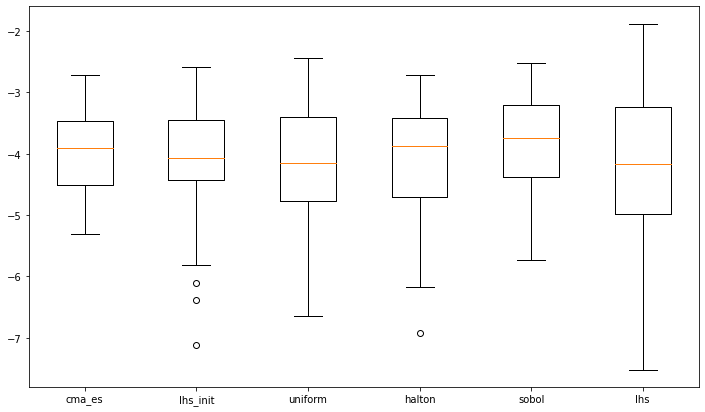

In [26]:
plt.rcParams["figure.figsize"] = (12, 7)

methods = ['cma_es', 'lhs_init', 'uniform', 'halton', 'sobol', 'lhs']
plt.boxplot([np.log(stats[method + '_regret'].div(stats['abs_norm'])) for method in methods])
plt.xticks(list(range(1, len(methods) + 1)), methods)

([<matplotlib.axis.XTick at 0x7fcc31ac51d0>,
 [Text(0, 0, 'cma_es'),
  Text(0, 0, 'lhs_init'),
  Text(0, 0, 'uniform'),
  Text(0, 0, 'halton'),
  Text(0, 0, 'sobol'),
  Text(0, 0, 'lhs')])

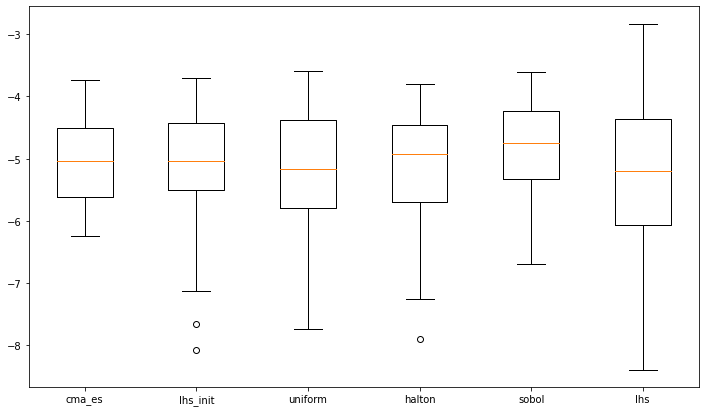

In [27]:
plt.rcParams["figure.figsize"] = (12, 7)

methods = ['cma_es', 'lhs_init', 'uniform', 'halton', 'sobol', 'lhs']
plt.boxplot([np.log(stats[method + '_regret'].div(stats['minmax_norm'])) for method in methods])
plt.xticks(list(range(1, len(methods) + 1)), methods)